In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import statistics as stats
stock_data = pd.read_csv('data/indexData.csv')
print(stock_data.columns)

Index(['Index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
import pandas as pd
import numpy as np

def calculate_features(df, stock_id_column='Index'):
    try:
        # Create copy to avoid modifying original data
        df_features = df.copy()
        
        # Ensure we have a stock identifier column
        if stock_id_column not in df_features.columns:
            raise KeyError(f"Missing stock identifier column: {stock_id_column}")
        
        # Set multi-index of [Symbol, Date] if not already set
        if not df_features.index.nlevels == 2:
            df_features = df_features.set_index([stock_id_column, 'Date'])
            
        # Function to calculate features for a single stock
        def calculate_single_stock_features(stock_data):
            # Returns
            stock_data['Returns'] = stock_data['Adj Close'].pct_change()
            
            # Moving Averages
            stock_data['MA10'] = stock_data['Adj Close'].rolling(window=10).mean()
            stock_data['MA50'] = stock_data['Adj Close'].rolling(window=50).mean()
            
            # Volatility
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=20).std()
            
            # RSI
            delta = stock_data['Adj Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            stock_data['RSI'] = 100 - (100 / (1 + rs))
            
            # ATR
            high_low = stock_data['High'] - stock_data['Low']
            high_close = abs(stock_data['High'] - stock_data['Adj Close'].shift())
            low_close = abs(stock_data['Low'] - stock_data['Adj Close'].shift())
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
            stock_data['ATR'] = tr.rolling(window=14).mean()
            
            # Normalized Volume
            stock_data['Volume_Norm'] = (stock_data['Volume'] - stock_data['Volume'].rolling(window=20).mean()) / stock_data['Volume'].rolling(window=20).std()
            
            # Price Gap (only calculate within same stock)
            stock_data['Gap'] = stock_data['Open'] - stock_data['Adj Close'].shift(1)
            
            # High-Low Range
            stock_data['HL_Range'] = (stock_data['High'] - stock_data['Low']) / stock_data['Adj Close']
            
            return stock_data
        
        # Apply calculations to each stock separately
        df_features = df_features.groupby(level=0, group_keys=False).apply(calculate_single_stock_features)
        
        # Clean up NaN values from rolling calculations
        df_features = df_features.dropna()
        
        return df_features
    
    except KeyError as e:
        print(f"Error: Missing required column - {str(e)}")
        print("Required columns: Symbol, Date, Open, High, Low, Close, Adj Close, Volume")
        return None
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None


In [4]:
stock_data = calculate_features(stock_data)
stock_data.head()

/var/folders/kb/k8m9t1p957xglv288k95hbn40000gn/T/ipykernel_76285/1116266625.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_data['Returns'] = stock_data['Adj Close'].pct_change()
/var/folders/kb/k8m9t1p957xglv288k95hbn40000gn/T/ipykernel_76285/1116266625.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_data['Returns'] = stock_data['Adj Close'].pct_change()
/var/folders/kb/k8m9t1p957xglv288k95hbn40000gn/T/ipykernel_76285/1116266625.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any

Open         High          Low        Close  \
Index Date                                                             
NYA   2001-01-03  6968.830078  6968.830078  6968.830078  6968.830078   
      2001-01-04  6894.810059  6894.810059  6894.810059  6894.810059   
      2001-01-05  6774.060059  6774.060059  6774.060059  6774.060059   
      2001-01-08  6759.049805  6759.049805  6759.049805  6759.049805   
      2001-01-09  6754.819824  6754.819824  6754.819824  6754.819824   

                    Adj Close        Volume   Returns         MA10  \
Index Date                                                           
NYA   2001-01-03  6968.830078  1.880700e+09  0.026989  6821.112988   
      2001-01-04  6894.810059  2.169400e+09 -0.010622  6834.022998   
      2001-01-05  6774.060059  1.430800e+09 -0.017513  6850.603027   
      2001-01-08  6759.049805  1.115500e+09 -0.002216  6861.124024   
      2001-01-09  6754.819824  1.191300e+09 -0.000626  6860.362988   

                         MA50  Volatility        RSI        ATR  Volume_Norm  \
Index Date                                                                     
NYA   2001-01-03  6832.605166    0.014492  51.767151  86.984305     4.248529   
      2001-01-04  6834.673369    0.013663  49.489345  90.987863     3.146759   
      2001-01-05  6833.427773    0.013989  48.014781  93.782157     1.700829   
      2001-01-08  6834.005166    0.013993  51.454465  87.512905     1.119444   
      2001-01-09  6835.136562    0.013426  47.979992  82.248640     1.109720   

                         Gap  HL_Range  
Index Date                              
NYA   2001-01-03  183.140137       0.0  
      2001-01-04  -74.020019       0.0  
      2001-01-05 -120.750000       0.0  
      2001-01-08  -15.010254       0.0  
      2001-01-09   -4.229981       0.0

In [5]:
stock_data.columns
stock_data.ffill()
stock_data.bfill()

Open         High          Low        Close  \
Index Date                                                             
NYA   2001-01-03  6968.830078  6968.830078  6968.830078  6968.830078   
      2001-01-04  6894.810059  6894.810059  6894.810059  6894.810059   
      2001-01-05  6774.060059  6774.060059  6774.060059  6774.060059   
      2001-01-08  6759.049805  6759.049805  6759.049805  6759.049805   
      2001-01-09  6754.819824  6754.819824  6754.819824  6754.819824   
...                       ...          ...          ...          ...   
N100  2021-05-27  1241.119995  1251.910034  1241.119995  1247.069946   
      2021-05-28  1249.469971  1259.209961  1249.030029  1256.599976   
      2021-05-31  1256.079956  1258.880005  1248.140015  1248.930054   
      2021-06-01  1254.609985  1265.660034  1254.609985  1258.579956   
      2021-06-02  1258.489990  1263.709961  1258.239990  1263.619995   

                    Adj Close        Volume   Returns         MA10  \
Index Date                                                           
NYA   2001-01-03  6968.830078  1.880700e+09  0.026989  6821.112988   
      2001-01-04  6894.810059  2.169400e+09 -0.010622  6834.022998   
      2001-01-05  6774.060059  1.430800e+09 -0.017513  6850.603027   
      2001-01-08  6759.049805  1.115500e+09 -0.002216  6861.124024   
      2001-01-09  6754.819824  1.191300e+09 -0.000626  6860.362988   
...                       ...           ...       ...          ...   
N100  2021-05-27  1247.069946  3.796964e+08  0.002935  1237.098010   
      2021-05-28  1256.599976  1.607734e+08  0.007642  1238.969006   
      2021-05-31  1248.930054  9.117370e+07 -0.006104  1240.393018   
      2021-06-01  1258.579956  1.551799e+08  0.007727  1242.871008   
      2021-06-02  1263.619995  1.484650e+08  0.004005  1247.706006   

                         MA50  Volatility        RSI        ATR  Volume_Norm  \
Index Date                                                                     
NYA   2001-01-03  6832.605166    0.014492  51.767151  86.984305     4.248529   
      2001-01-04  6834.673369    0.013663  49.489345  90.987863     3.146759   
      2001-01-05  6833.427773    0.013989  48.014781  93.782157     1.700829   
      2001-01-08  6834.005166    0.013993  51.454465  87.512905     1.119444   
      2001-01-09  6835.136562    0.013426  47.979992  82.248640     1.109720   
...                       ...         ...        ...        ...          ...   
N100  2021-05-27  1218.598394    0.009329  49.474890  14.845006     3.373230   
      2021-05-28  1220.061594    0.009350  56.065841  15.083575    -0.537382   
      2021-05-31  1221.350796    0.009420  66.078765  13.536429    -1.615779   
      2021-06-01  1222.990996    0.008884  69.242343  13.981428    -0.494181   
      2021-06-02  1224.753997    0.008149  70.611320  12.374285    -0.550275   

                         Gap  HL_Range  
Index Date                              
NYA   2001-01-03  183.140137  0.000000  
      2001-01-04  -74.020019  0.000000  
      2001-01-05 -120.750000  0.000000  
      2001-01-08  -15.010254  0.000000  
      2001-01-09   -4.229981  0.000000  
...                      ...       ...  
N100  2021-05-27   -2.300049  0.008652  
      2021-05-28    2.400025  0.008101  
      2021-05-31   -0.520020  0.008599  
      2021-06-01    5.679931  0.008780  
      2021-06-02   -0.089966  0.004329  

[53208 rows x 15 columns]

In [6]:
feature_scaler = StandardScaler()
feature_columns = ['Open','High','Low','Close','Volume','Returns','MA10', 'MA50', 'RSI', 'ATR', 'Volume_Norm', 'Volatility']
scaled_features = feature_scaler.fit_transform(stock_data[feature_columns])

target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(stock_data[['Adj Close']])

In [7]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):

        X.append(data[i:(i + seq_length)])
        y.append(target[i + seq_length])
        
    return np.array(X), np.array(y)


In [8]:
def check_data_quality(df):
  
    print("Missing values:\n", df.isnull().sum())
    
    print("\nInfinite values:\n", np.isinf(df).sum())
    
    z_scores = stat.zscore(df)
    print("\nExtreme outliers:\n", (abs(z_scores) > 3).sum())

def clean_data(df):
    
    df = df.fillna(method='ffill')
    
    df = df.fillna(method='bfill')
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(method='ffill')
    
    return df

In [9]:
X = scaled_features
y = scaled_target

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [11]:
class StockPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(StockPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

In [12]:
import time

model = StockPricePredictor(input_size=12)
model
metric = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
batch_size = 64
best_loss = float('inf')
patience = 10
patience_counter = 0

l2_lamda = 0.1
train_losses = []
val_losses = []
# DataLoader with drop_last to ensure consistent batch sizes
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1)  # Ensure shape matches predictions
        # Forward pass
        predictions = model(X_batch)
        loss = metric(predictions, y_batch)

        l2_reg = sum(param.norm(2) for param in model.parameters())
        loss += l2_lamda * l2_reg

        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

    if (epoch+1) % 75 == 0 & epoch != (epochs - 1):
        time.sleep(45)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.2f}, Average Loss: {avg_loss:.2f}")

Epoch 1/25, Loss: 0.07, Average Loss: 0.26
Epoch 2/25, Loss: 0.05, Average Loss: 0.06
Epoch 3/25, Loss: 0.07, Average Loss: 0.06
Epoch 4/25, Loss: 0.06, Average Loss: 0.06
Epoch 5/25, Loss: 0.06, Average Loss: 0.06
Epoch 6/25, Loss: 0.06, Average Loss: 0.06
Epoch 7/25, Loss: 0.06, Average Loss: 0.06
Epoch 8/25, Loss: 0.06, Average Loss: 0.06
Epoch 9/25, Loss: 0.05, Average Loss: 0.06
Epoch 10/25, Loss: 0.07, Average Loss: 0.06
Epoch 11/25, Loss: 0.05, Average Loss: 0.06
Epoch 12/25, Loss: 0.07, Average Loss: 0.06
Epoch 13/25, Loss: 0.07, Average Loss: 0.06
Epoch 14/25, Loss: 0.07, Average Loss: 0.06
Epoch 15/25, Loss: 0.05, Average Loss: 0.06
Epoch 16/25, Loss: 0.05, Average Loss: 0.06
Epoch 17/25, Loss: 0.09, Average Loss: 0.06
Epoch 18/25, Loss: 0.07, Average Loss: 0.06
Epoch 19/25, Loss: 0.06, Average Loss: 0.06
Epoch 20/25, Loss: 0.08, Average Loss: 0.06
Epoch 21/25, Loss: 0.06, Average Loss: 0.06
Epoch 22/25, Loss: 0.06, Average Loss: 0.06
Epoch 23/25, Loss: 0.05, Average Loss: 0.

In [13]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = metric(test_predictions, y_test_tensor)
    val_losses.append(test_loss.item())
    print(f"Test Loss: {test_loss.item():.2f}")

Test Loss: 0.06


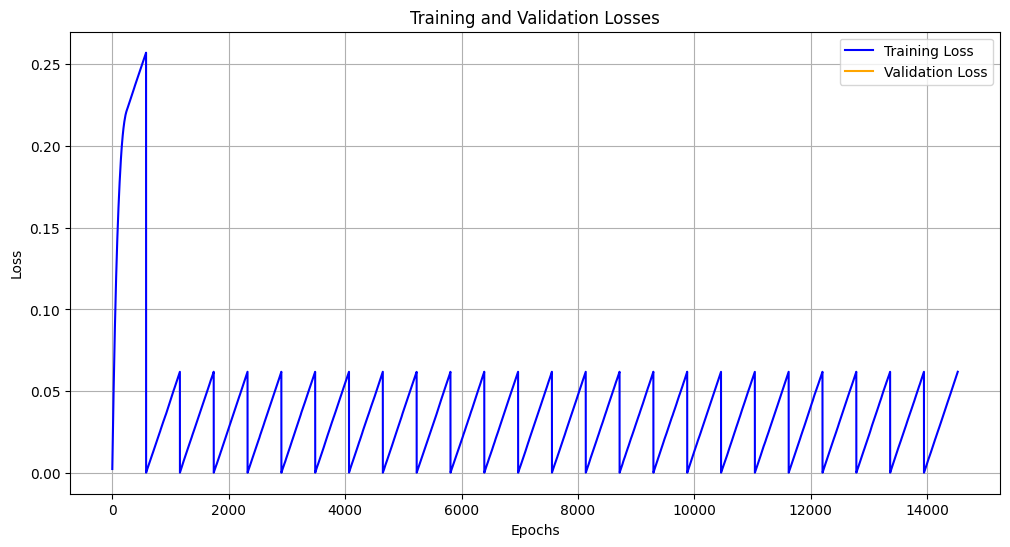

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [15]:
np.random.seed(42)

# Create a date range
dates = pd.date_range(start='2001-01-01', end='2021-06-02', freq='B')  # Business days

num_samples = len(dates)
data = {
    'Open': np.random.uniform(low=6000, high=13000, size=num_samples),
    'High': np.random.uniform(low=6000, high=13000, size=num_samples),
    'Low': np.random.uniform(low=6000, high=13000, size=num_samples),
    'Close': np.random.uniform(low=6000, high=13000, size=num_samples),
    'Adj Close': np.random.uniform(low=6000, high=13000, size=num_samples),
    'Volume': np.random.randint(low=1e7, high=1e9, size=num_samples),
    'Returns': np.random.normal(loc=0, scale=0.01, size=num_samples),  # Daily returns
    'MA10': np.random.uniform(low=6000, high=13000, size=num_samples),
    'MA50': np.random.uniform(low=6000, high=13000, size=num_samples),
    'Volatility': np.random.uniform(low=0, high=0.02, size=num_samples),
    'RSI': np.random.uniform(low=0, high=100, size=num_samples),
    'ATR': np.random.uniform(low=0, high=5, size=num_samples),
    'Volume_Norm': np.random.uniform(low=0, high=1, size=num_samples),
    'Gap': np.random.uniform(low=-100, high=100, size=num_samples),
    'HL_Range': np.random.uniform(low=0, high=100, size=num_samples)
}

# Create a DataFrame
df = pd.DataFrame(data, index=dates)
df.index.name = 'Date'
df.index = pd.MultiIndex.from_product([['NYA'], df.index], names=['Index', 'Date'])

# Display the first few rows of the DataFrame
print(df.head())


                          Open         High          Low         Close  \
Index Date                                                               
NYA   2001-01-01   8621.780832  9076.940592  9024.820229   9678.424611   
      2001-01-02  12655.000145  9573.220919  9771.735571   8319.751614   
      2001-01-03  11123.957593  7811.546859  9122.800150  12860.002909   
      2001-01-04  10190.609389  8215.199916  9953.728198   8237.869807   
      2001-01-05   7092.130483  6608.769142  9293.535553  11209.302751   

                     Adj Close     Volume   Returns          MA10  \
Index Date                                                          
NYA   2001-01-01  12925.552498  148124086  0.001067   9318.919742   
      2001-01-02  10274.494466  453844613 -0.001069  11473.745550   
      2001-01-03  10290.289059   18068691 -0.002296   8366.991964   
      2001-01-04  11280.989204  914311728 -0.005102   9175.898547   
      2001-01-05   7624.972667  650319571  0.000860  10398.478125  

In [37]:
from metrics import calculate_all_features
data = calculate_all_features(pd.read_csv('data/IndexProcessed.csv'))
chart_data = data.loc['NYA']

In [40]:
chart_data.head()

,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Returns,MA10,MA50,Volatility,RSI,ATR,Volume_Norm,Gap,HL_Range
Date,,,,,,,,,,,,,,,,
2001-01-03,6968.830078,6968.830078,6968.830078,6968.830078,6968.830078,1.880700e+09,6968.830078,0.026989,6821.112988,6832.605166,0.014492,51.767151,86.984305,4.248529,183.140137,0.0
2001-01-04,6894.810059,6894.810059,6894.810059,6894.810059,6894.810059,2.169400e+09,6894.810059,-0.010622,6834.022998,6834.673369,0.013663,49.489345,90.987863,3.146759,-74.020019,0.0
2001-01-05,6774.060059,6774.060059,6774.060059,6774.060059,6774.060059,1.430800e+09,6774.060059,-0.017513,6850.603027,6833.427773,0.013989,48.014781,93.782157,1.700829,-120.750000,0.0
2001-01-08,6759.049805,6759.049805,6759.049805,6759.049805,6759.049805,1.115500e+09,6759.049805,-0.002216,6861.124024,6834.005166,0.013993,51.454465,87.512905,1.119444,-15.010254,0.0
2001-01-09,6754.819824,6754.819824,6754.819824,6754.819824,6754.819824,1.191300e+09,6754.819824,-0.000626,6860.362988,6835.136562,0.013426,47.979992,82.248640,1.109720,-4.229981,0.0
